# Sentencepiece 사용하기

|평가문항|상세기준|
|---|---|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.

# 1. SentencePiece 설치
* https://github.com/google/sentencepiece


* 정리
 * Google OpenSource 기반 Sentence Tokenizer/Detokenizer로서 BPE(byte-pair-encoding)와 unigram 2가지 subword Tokenizing 모델 중 하나를 선택해서 사용할 수 있도록 패키징 한 것.
 * SentencePiece는 pre/postprocessing에 의존하지 않는 순수한 end-to-end system을 만들 수 있다.

In [1]:
# !pip install sentencepiece

# 라이브러리 및 패키지

In [2]:
import re
import os
import os.path
import pandas as pd
import numpy as np
import urllib.request

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

from collections import Counter
from konlpy.tag import Mecab
import sentencepiece as spm

import gensim
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

from keras.layers import LSTM, GRU, Dense, Conv1D
from keras.layers import Embedding, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore') # (action='default')

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# 2. SentencePiece 모델 학습

* 한국어의 형태소 분석과 품사 태깅, 기계 번역 연구를 위해 공개된 데이터
 * 한국어-영어 병렬을 이루는 말뭉치 중 한국어 부분

In [3]:
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


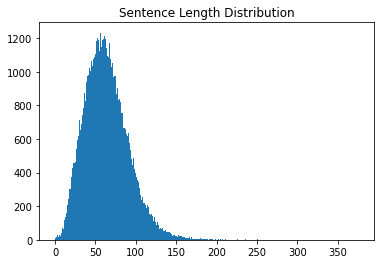

In [4]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

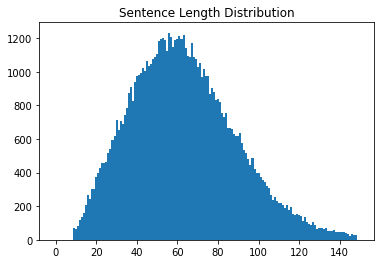

In [5]:
max_len = 150
min_len = 10

# 길이 10 미만 제거, 길이 150 미만 제거
# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [6]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 376892 Oct  4 06:22 korean_spm.model
-rw-r--r-- 1 root root 146388 Oct  4 06:22 korean_spm.vocab


SentencePiece 모델 학습 완료 및 korean_spm.model, korean_spm.vocab 파일 생성

# 3. Tokenizer 함수 작성

SentencePiece를 활용한 Tokenizer 함수 작성
1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list를 전달
2. 생성된 vocab 파일을 읽어와 {<word> : <idx>} 형태를 가지는 word_index 사전과 {<idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환
3. 리턴값인 tensor는 토큰화한 후 Encoding된 문장임. 바로 학습에 사용할 수 있도록 Padding 함.

In [7]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1244, 11, 306, 7, 3599, 11, 286, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [8]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre',maxlen=80)

    return tensor, word_index, index_word

In [9]:
my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 1949 5662    5    4 7975 1983    3]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  107 1638  101    4
     0  419   11    4   14    0 1969    3    3    3]]


# 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용
* 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
* 학습된 모델로 sp_tokenize() 메소드 구현하기
* 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
* KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
* (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

* data
 * https://github.com/e9t/nsmc/

In [10]:
train_data = pd.read_table('~/aiffel/sp_tokenizer/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sp_tokenizer/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 전처리

In [11]:
print('리뷰 개수:', len(train_data))
print('Nan 확인:', train_data.isnull().values.any())

리뷰 개수: 150000
Nan 확인: True


In [12]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any')

test_data.drop_duplicates(subset=['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "") 
test_data['document'].replace('', np.nan, inplace=True) 
test_data = test_data.dropna(how = 'any')

In [13]:
print('train_data 리뷰 개수:', len(train_data))
print('test_data 리뷰 개수:', len(test_data))

train_data 리뷰 개수: 145393
test_data 리뷰 개수: 48852


## 데이터 길이 분포 확인 및 적용

Data size: 143620
문장의 최단 길이: 1
문장의 최장 길이: 140
문장의 평균 길이: 33


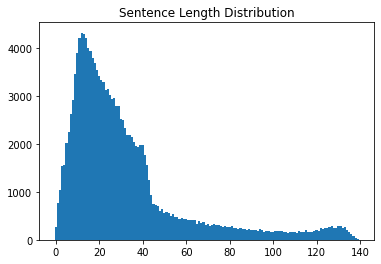

In [14]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(train_data['document']))
print("Data size:", len(cleaned_corpus))

for sen in train_data['document']:
    length = len(sen)
    
    # 문장 최소 길이 찾기
    if min_len > length:
        min_len = length
    
    # 문장 최대 길이 찾기
    if max_len < length:
        max_len = length
    
    # 전체 문장을 합쳐서 나온 길이
    sum_len += length
    
print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_data))

# 전체 길이를 0 벡터로 만듦. 
# 길이에 따른 문장의 수를 저장하기 위해서 0으로 이루어진 list를 만듦.
sentence_length = np.zeros((max_len), dtype=np.int)

# 0으로 이루어진 벡터에 문장 count를 더한 뒤 넣는다.
for sen in train_data['document']:
    sentence_length[len(sen)-1] += 1 

plt.bar(range(max_len), sentence_length, width=1.0) # 너비는 1.0씩 늘어나도록 설정
plt.title("Sentence Length Distribution")
plt.show()

* 데이터 편향으로 인해 학습이 잘 안될 것을 고려하여 maxlen 80 이상을 잘랐음. 
* minlen은 5-10이하는 자르려고 했으나 전체 분포를 생각했을 때 고르게 분포하고 있어서 제거 하지 않음.
 * 추후 학습이 잘 되지 않는다면 다시 고려해야 될 부분.

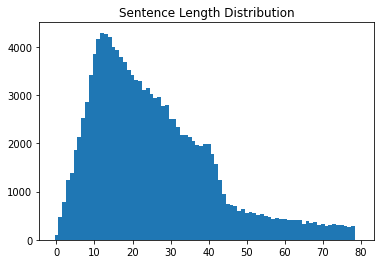

In [15]:
max_len = 80
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

## Sentencepiece 적용

Sentencepiece를 unigram과 BPE를 따로 확인해보기 위해 나눈다.

### Sentencepiece unigram

In [16]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_korean_spm01  --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l naver_korean_spm01*

-rw-r--r-- 1 root root 378413 Oct  4 06:22 naver_korean_spm01.model
-rw-r--r-- 1 root root 147946 Oct  4 06:22 naver_korean_spm01.vocab


### Sentencepiece BPE(Byte Pair Encoding)

In [17]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_korean_spm02 --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l naver_korean_spm02*

-rw-r--r-- 1 root root 373708 Oct  4 06:22 naver_korean_spm02.model
-rw-r--r-- 1 root root 118928 Oct  4 06:22 naver_korean_spm02.vocab


## 학습된 모델로 sp_tokenize() 메소드 구현하기

In [18]:
def sp_tokenize_unigram(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./naver_korean_spm01.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
    # 패딩을 하였다.
    
    #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor, word_index, index_word

In [19]:
def sp_tokenize_bpe(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))
   
    with open("./naver_korean_spm02.vocab", 'r') as f:
        vocab = f.readlines()
    
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})
    # 패딩을 하였다.
    
    #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')
    
    return tensor, word_index, index_word

## 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기

In [20]:
s_unigram = spm.SentencePieceProcessor()
s_unigram.Load('naver_korean_spm01.model')

True

In [21]:
def load_data_unigram(train_data, test_data, stpiece_model):
    sentences =[]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    #train데이터 토큰화
    sentences = train_data['document'] 
    # unigram
    tensor, word_index, index_word = sp_tokenize_unigram(s_unigram, sentences)
    
    #train문장데이터를 수치화로 표현화한 리스트
    X_train = []
    ## 수치화된 문장(텐서)를 리스트(sentences_index)에 넣어준다. 
    for array in tensor:
        X_train.append(array)
        
    #test데이터 토큰화
    sentences = test_data['document']
    # unigram
    tensor, word_index, index_word = sp_tokenize_unigram(s_unigram, sentences)
    
    # test문장데이터를 수치화로 표현화한 리스트
    X_test = []
    for array in tensor:
        X_test.append(array)
        
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_index

In [22]:
s_bpe = spm.SentencePieceProcessor()
s_bpe.Load('naver_korean_spm02.model')

True

In [23]:
def load_data_bpe(train_data, test_data, stpiece_model):
    sentences =[]
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    #train데이터 토큰화
    sentences = train_data['document'] 
    # BPE
    tensor, word_index, index_word = sp_tokenize_bpe(s_bpe, sentences)
    
    #train문장데이터를 수치화로 표현화한 리스트
    X_train = []
    ## 수치화된 문장(텐서)를 리스트(sentences_index)에 넣어준다. 
    for array in tensor:
        X_train.append(array)
        
    #test데이터 토큰화
    sentences = test_data['document']
    # bpe
    tensor, word_index, index_word = sp_tokenize_bpe(s_bpe, sentences)
    
    # test문장데이터를 수치화로 표현화한 리스트
    X_test = []
    for array in tensor:
        X_test.append(array)
        
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_index

In [24]:
#unigram
X_train, y_train, X_test, y_test, word_to_index = load_data_unigram(train_data, test_data,0)

In [25]:
# bpe
X_train_, y_train_, X_test_, y_test_, word_to_index_ = load_data_bpe(train_data, test_data,1)

In [26]:
print(X_train.shape)
print(X_train_.shape)

(143620, 133)
(143620, 111)


### 데이터셋 나누기

In [27]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(X_train.shape)
print(y_train.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(143620, 133)
(143620,)
(133620, 133)
(133620,)


In [28]:
# validation set 10000건 분리
X_val_ = X_train_[:10000]   
y_val_ = y_train_[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train_ = X_train_[10000:]  
partial_y_train_ = y_train_[10000:]

print(X_train_.shape)
print(y_train_.shape)
print(partial_X_train_.shape)
print(partial_y_train_.shape)

(143620, 111)
(143620,)
(133620, 111)
(133620,)


### 모델
LSTM 모델을 사용

In [29]:
vocab_size = 8000    # 어휘 사전의 크기입니다(8,000개의 단어)
word_vector_dim = 150  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


#LSTM
model = keras.Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 150)         1200000   
_________________________________________________________________
lstm (LSTM)                  (None, 150)               180600    
_________________________________________________________________
dense (Dense)                (None, 10)                1510      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,382,121
Trainable params: 1,382,121
Non-trainable params: 0
_________________________________________________________________


In [30]:
vocab_size = 8000    # 어휘 사전의 크기입니다(8,000개의 단어)
word_vector_dim = 150  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


#LSTM
model_ = keras.Sequential()
model_.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_.add(LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어
model_.add(Dense(10, activation='relu'))
model_.add(Dense(1, activation='sigmoid')) 
model_.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 150)         1200000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1510      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,382,121
Trainable params: 1,382,121
Non-trainable params: 0
_________________________________________________________________


### Sentencepiece unigram

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model = model.fit(partial_X_train, partial_y_train,
                          epochs=epochs,
                          batch_size=512,
                          validation_data=(X_val, y_val),
                          verbose=2)

results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

Epoch 1/10
261/261 - 35s - loss: 0.4164 - accuracy: 0.8044 - val_loss: 0.3440 - val_accuracy: 0.8476
Epoch 2/10
261/261 - 31s - loss: 0.3255 - accuracy: 0.8580 - val_loss: 0.3313 - val_accuracy: 0.8543
Epoch 3/10
261/261 - 31s - loss: 0.2965 - accuracy: 0.8698 - val_loss: 0.3312 - val_accuracy: 0.8585
Epoch 4/10
261/261 - 31s - loss: 0.2681 - accuracy: 0.8825 - val_loss: 0.3408 - val_accuracy: 0.8581
Epoch 5/10
261/261 - 32s - loss: 0.2446 - accuracy: 0.8932 - val_loss: 0.3533 - val_accuracy: 0.8524
Epoch 6/10
261/261 - 31s - loss: 0.2222 - accuracy: 0.9035 - val_loss: 0.3797 - val_accuracy: 0.8536
Epoch 7/10
261/261 - 32s - loss: 0.1997 - accuracy: 0.9137 - val_loss: 0.3914 - val_accuracy: 0.8508
Epoch 8/10
261/261 - 31s - loss: 0.1771 - accuracy: 0.9246 - val_loss: 0.4273 - val_accuracy: 0.8460
Epoch 9/10
261/261 - 32s - loss: 0.1556 - accuracy: 0.9335 - val_loss: 0.4905 - val_accuracy: 0.8441
Epoch 10/10
261/261 - 32s - loss: 0.1361 - accuracy: 0.9422 - val_loss: 0.5393 - val_accura

### Sentencepiece BPE

In [32]:
model_.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model_ = model_.fit(partial_X_train_, partial_y_train_,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(X_val_, y_val_),
                            verbose=2)

results = model_.evaluate(X_test_,  y_test_, verbose=2)
print(results)

Epoch 1/10
261/261 - 29s - loss: 0.4434 - accuracy: 0.7956 - val_loss: 0.3465 - val_accuracy: 0.8464
Epoch 2/10
261/261 - 27s - loss: 0.3277 - accuracy: 0.8577 - val_loss: 0.3343 - val_accuracy: 0.8504
Epoch 3/10
261/261 - 27s - loss: 0.2997 - accuracy: 0.8711 - val_loss: 0.3377 - val_accuracy: 0.8509
Epoch 4/10
261/261 - 27s - loss: 0.2721 - accuracy: 0.8825 - val_loss: 0.3470 - val_accuracy: 0.8523
Epoch 5/10
261/261 - 27s - loss: 0.2476 - accuracy: 0.8922 - val_loss: 0.3540 - val_accuracy: 0.8496
Epoch 6/10
261/261 - 27s - loss: 0.2254 - accuracy: 0.9021 - val_loss: 0.3837 - val_accuracy: 0.8488
Epoch 7/10
261/261 - 27s - loss: 0.2053 - accuracy: 0.9112 - val_loss: 0.4007 - val_accuracy: 0.8453
Epoch 8/10
261/261 - 27s - loss: 0.1877 - accuracy: 0.9189 - val_loss: 0.4393 - val_accuracy: 0.8374
Epoch 9/10
261/261 - 27s - loss: 0.1700 - accuracy: 0.9262 - val_loss: 0.4692 - val_accuracy: 0.8382
Epoch 10/10
261/261 - 27s - loss: 0.1497 - accuracy: 0.9348 - val_loss: 0.5537 - val_accura

## KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

In [33]:
# 기존에 불러왔던 데이터를 동일하게 사용
train_data.head(3)

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


### Mecab

In [34]:
tokenizer = Mecab()

### 전처리

In [35]:
# stopwords 추가
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를',
             '으로','자','에','와','한','하다','이','있','하','것','들',
             '그','되','수','이','보','않','없','나','사람','주','아니',
             '등','같','우리','때','년','가','한','지','대하','오','말',
             '일','그렇','위하','때문','그것','두','말하','알','그러나',
             '받','못하','일','그런','또','문제','더','사회','많','그리고',
             '좋','크','따르','중','나오','가지','씨','시키','만들','지금',
             '생각하','그러','속','하나','집','살','모르','적','월','데',
             '자신','안','어떤','내','경우','명','생각','시간','그녀',
             '다시','이런','앞','보이','번','나','다른','어떻','여자','개',
             '전','들','사실','이렇','점','싶','말','정도','좀','원','잘','통하',
             '소리','놓']

stopwords = set(stopwords) # 117 -> 106

In [36]:
# 데이터의 중복 제거   
# NaN 결측치 제거   
# 한국어 토크나이저로 토큰화   
# 불용어(Stopwords) 제거   
# 사전word_to_index 구성   
# 텍스트 스트링을 사전 인덱스 스트링으로 변환   
# X_train, y_train, X_test, y_test, word_to_index 리턴  

def load_data_macab(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    #print(X_train[0])
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    ## X_train, y_train, X_test, y_test, word_to_index 리턴    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [37]:
X_train__, y_train__, X_test__, y_test__, word_to_index__ = load_data_macab(train_data, test_data)

### 문장 최대 길이 maxlen 찾기

In [38]:
total_data_text = list(X_train__) + list(X_test__)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  11.404085225171738
문장길이 최대 :  70
문장길이 표준편차 :  9.246934819654808
pad_sequences maxlen :  29
전체 문장의 0.9326281580550911%가 maxlen 설정값 이내에 포함됩니다. 


### Pading 및 maxlen 적용

In [39]:
#RNN은 입력데이터가 순차적으로 처리되기 때문에 뒤부분 입력이 패딩값(padding)으로 채워지면 비효율적이다.
X_train__ = keras.preprocessing.sequence.pad_sequences(X_train__,
                                                     value=word_to_index__["<PAD>"],
                                                     padding='pre',# 혹은'post'
                                                     maxlen=maxlen)

X_test__ = keras.preprocessing.sequence.pad_sequences(X_test__,
                                                    value=word_to_index__["<PAD>"],
                                                    padding='pre', # 혹은 'post'
                                                    maxlen=maxlen)
print(X_train__.shape)

(143620, 29)


In [40]:
# validation set 10000건 분리
X_val__ = X_train__[:10000]   
y_val__ = y_train__[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train__ = X_train__[10000:]  
partial_y_train__ = y_train__[10000:]

print(X_train__.shape)
print(y_train__.shape)
print(partial_X_train__.shape)
print(partial_y_train__.shape)

(143620, 29)
(143620,)
(133620, 29)
(133620,)


In [41]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 150  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
model__ = keras.Sequential()
model__.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model__.add(LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 변경가능
model__.add(Dense(32, activation='relu'))
model__.add(Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model__.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 150)         1500000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4832      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,685,465
Trainable params: 1,685,465
Non-trainable params: 0
_________________________________________________________________


In [42]:
model__.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_model__ = model__.fit(partial_X_train__, partial_y_train__,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(X_val__, y_val__),
                              verbose=2)

results = model__.evaluate(X_test__,  y_test__, verbose=2)
print(results)

Epoch 1/10
261/261 - 10s - loss: 0.4247 - accuracy: 0.7999 - val_loss: 0.3622 - val_accuracy: 0.8340
Epoch 2/10
261/261 - 8s - loss: 0.3454 - accuracy: 0.8477 - val_loss: 0.3566 - val_accuracy: 0.8380
Epoch 3/10
261/261 - 8s - loss: 0.3163 - accuracy: 0.8607 - val_loss: 0.3608 - val_accuracy: 0.8404
Epoch 4/10
261/261 - 8s - loss: 0.2886 - accuracy: 0.8731 - val_loss: 0.3721 - val_accuracy: 0.8400
Epoch 5/10
261/261 - 8s - loss: 0.2654 - accuracy: 0.8835 - val_loss: 0.3936 - val_accuracy: 0.8352
Epoch 6/10
261/261 - 8s - loss: 0.2429 - accuracy: 0.8936 - val_loss: 0.4262 - val_accuracy: 0.8281
Epoch 7/10
261/261 - 8s - loss: 0.2224 - accuracy: 0.9024 - val_loss: 0.4622 - val_accuracy: 0.8278
Epoch 8/10
261/261 - 8s - loss: 0.2042 - accuracy: 0.9119 - val_loss: 0.4858 - val_accuracy: 0.8278
Epoch 9/10
261/261 - 8s - loss: 0.1847 - accuracy: 0.9206 - val_loss: 0.5813 - val_accuracy: 0.8245
Epoch 10/10
261/261 - 8s - loss: 0.1690 - accuracy: 0.9273 - val_loss: 0.6379 - val_accuracy: 0.818

### 모델 학습 시각화

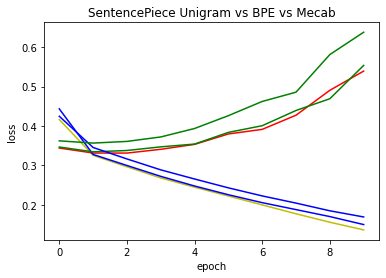

In [63]:
fig, loss_ax = plt.subplots()

loss_ax.plot(history_model.history['loss'], 'y', label='train loss')
loss_ax.plot(history_model.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.plot(history_model_.history['loss'], 'b', label='train loss')
loss_ax.plot(history_model_.history['val_loss'], 'g', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.plot(history_model__.history['loss'], 'b', label='train loss')
loss_ax.plot(history_model__.history['val_loss'], 'g', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

plt.title('SentencePiece Unigram vs BPE vs Mecab')
plt.show()

모델이 중점이 아니기 때문에 대략적인 확인만 하였다. loss와 val_loss의 차이가 심한 것으로 보아 Overfitting으로 사료되며 모델을 바꿔야 성능향상의 차이를 명확히 알 수 있을듯 하다

## 비교

* SentencePiece Unigram 및 BPE 그리고 Mecab 총 3가지를 각각 비교했지만 큰 차이가 없었다.
* SentencePiece 모델의 model_type, vocab_size 등을 변경했지만 아주 미약한 성능 개선이 있거나 별다른 차이가 없었다.

# 참고
* [Wikidocs: SentencepieceBPE와 Unigram](https://wikidocs.net/22592)